# library importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import entropy, wasserstein_distance, spearmanr
from scipy.spatial.distance import jensenshannon
from typing import Tuple, Dict, Any, Union, Optional, List
import plotly.graph_objects as go

# Specify the path to our custom importer
import sys
sys.path.append('..')
from custom_imputer import KZImputer

# sets for graphics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
seed_value = 42

max_gap = 5
kz = KZImputer(max_gap_size = max_gap, use_universal_handler = False)

# definition of additional functions

In [10]:
gap_types = [1, 2, 3, 4, 5]
max(gap_types)

5

In [6]:

# def evaluate_metrics(
#     imputed_series: np.ndarray,
#     gap_info: Dict[str, Union[np.ndarray, Dict[int, float]]],
#     full_checking_flag: bool = False
# ) -> Dict[str, float]:
#     """
#     Assessing the quality of gap recovery.

#     Parameters:
#     - imputed_series: np.ndarray — recovered series with gaps.
#     - gap_info: dict containing:
#     - 'missing_indices': np.ndarray(bool) — gap mask.
#     - 'true_values': dict {index: value} — values ​​before zeroing.
#     - full_checking_flag: bool — whether to compare recovery for the entire series (True), or only for missing points (False).

#     Returns:
#     - dict with MAE, RMSE, MAPE, R², NRMSE, JS divergence, Wasserstein distance, Correlation diff metrics.
#     """
#     missing_indices = gap_info['missing_indices']
#     true_values_dict = gap_info['true_values']

#     if full_checking_flag:
#         full_true = imputed_series.copy()
#         for i, val in true_values_dict.items():
#             full_true.iloc[i] = val
#         true_values = full_true.values
#         imputed_values = imputed_series.values
#     else:
#         indices = list(true_values_dict.keys())
#         true_values = np.array([true_values_dict[i] for i in indices])
#         imputed_values = np.array([imputed_series.iloc[i] for i in indices])

#     # del all NaN positions
#     valid_mask = ~np.isnan(true_values) & ~np.isnan(imputed_values)
#     true_values = true_values[valid_mask]
#     imputed_values = imputed_values[valid_mask]

#     # If there are no valid pairs left, return NaN metrics
#     if len(true_values) == 0:
#         return {
#             "MAE": np.nan,
#             "RMSE": np.nan,
#             "MAPE": np.nan,
#             "R2": np.nan,
#             "NRMSE": np.nan,
#             "JS_Divergence": np.nan,
#             "Wasserstein": np.nan,
#             "Correlation_Diff": np.nan,
#         }

#     # Metrics for missing or complete data
#     mae = mean_absolute_error(true_values, imputed_values)
#     rmse = np.sqrt(mean_squared_error(true_values, imputed_values))

#     mask = np.abs(true_values) > 1e-2
#     mape = np.mean(np.abs((true_values[mask] - imputed_values[mask]) / true_values[mask])) * 100 if np.any(mask) else np.nan
#     r2 = r2_score(true_values, imputed_values)
#     nrmse = rmse / (true_values.max() - true_values.min())

#     # Distribution metrics
#     full_true_array = np.array(imputed_series.copy())
#     for idx, true_val in true_values_dict.items():
#         full_true_array[idx] = true_val

#     js = jensenshannon(
#         np.histogram(full_true_array[~np.isnan(full_true_array)], bins=20, density=True)[0],
#         np.histogram(imputed_series[~np.isnan(imputed_series)], bins=20, density=True)[0]
#     )

#     wd = wasserstein_distance(
#         full_true_array[~np.isnan(full_true_array)],
#         imputed_series[~np.isnan(imputed_series)]
#     )

#     valid_mask = ~np.isnan(full_true_array) & ~np.isnan(imputed_series)
#     corr_orig = np.corrcoef(full_true_array[valid_mask], full_true_array[valid_mask])[0, 1]  # или просто = 1.0
#     corr_imputed = np.corrcoef(full_true_array[valid_mask], imputed_series[valid_mask])[0, 1]
#     corr_diff = np.abs(corr_orig - corr_imputed)

#     return {
#         "MAE": mae,
#         "RMSE": rmse,
#         "MAPE": mape,
#         "R2": r2,
#         "NRMSE": nrmse,
#         "JS_Divergence": js,
#         "Wasserstein": wd,
#         "Correlation_Diff": corr_diff,
#     }


def generate_gaps(
    clean_slice: np.ndarray,
    perc_gaps: float = 5,
    seed_value: int = 42,
    all_gaps_flag: bool = True,
    show_stats_flag: bool = False,
    gap_type_weights: Optional[List[float]] = None
) -> Tuple[np.ndarray, Dict[str, Union[np.ndarray, Dict[int, float]]]]:
    """
    Generate synthetic gaps in a series.

    Parameters:
    - clean_slice: numpy.ndarray (1D) — original series without gaps.
    - perc_gaps: float — percentage of gaps from the series length (0–100).
    - seed_value: int — fixed value for reproducibility.
    - all_gaps_flag: bool — whether to use all types of gaps from 1 to 5.
    - show_stats_flag: bool — whether to display summary statistics.
    - gap_type_weights: List of weights for each type of gap, sum = 1

    Returns:
    - test_series: numpy.ndarray — series with gaps.
    - gap_info: dict:
    - 'missing_indices': np.ndarray(bool) — mask of gaps.
    - 'true_values': dict {index: value} — true values ​​before zeroing.
    """
    np.random.seed(seed_value)
    test_series = clean_slice.copy()
    length = len(test_series)
    total_gaps = int((perc_gaps / 100) * length)

    if all_gaps_flag:
        gap_types = [1, 2, 3, 4, 5]
        if gap_type_weights is None:
            weights = np.ones(len(gap_types)) / len(gap_types)
        else:
            weights = np.array(gap_type_weights, dtype=float)
            if len(weights) != len(gap_types):
                raise ValueError("gap_type_weights must have length 5.")
            weights = weights / weights.sum()
    else:
        gap_types = list(np.random.choice([1, 2, 3, 4, 5],
                                          size=np.random.randint(3, 6),
                                          replace=False))
        weights = None                                    # выбор без весов

    gap_counts = {k: 0 for k in gap_types}
    gap_true_values = {}
    gap_mask = np.zeros_like(test_series, dtype=bool)

    current_missing = 0
    tries = 0
    max_tries = total_gaps * 10

    while current_missing < total_gaps and tries < max_tries:
        gap_len = np.random.choice(gap_types, p=weights) if weights is not None else np.random.choice(gap_types)
        if current_missing + gap_len > total_gaps:
            tries += 1
            continue

        idx = np.random.randint(5, length - gap_len - 5)
        if np.any(gap_mask[idx:idx+gap_len]):
            tries += 1
            continue

        # Save true values
        valid_indices = [i for i in range(idx, idx + gap_len) if test_series.iloc[i] != 0 and not gap_mask[i]]
        if len(valid_indices) < gap_len:
            tries += 1
            continue

        for i in valid_indices:
            gap_true_values[i] = test_series.iloc[i]
            test_series.iloc[i] = np.nan
            gap_mask[i] = True
        gap_counts[gap_len] += 1
        current_missing += gap_len

    if show_stats_flag:
        total_inserted = sum([k * v for k, v in gap_counts.items()])
        rows = []
        for k in sorted(gap_counts):
            count = gap_counts[k]
            total_vals = count * k
            percent = 100 * total_vals / total_inserted if total_inserted else 0
            rows.append({
                'Type': k,
                'Amount': count,
                'Total': total_vals,
                'Percent': f"{percent:.2f}%"
            })
        df_stats = pd.DataFrame(rows)
        print("Gap Type Statistics:\n")
        print(df_stats.to_string(index=False))
        print(f"\nTotal gaps: {total_inserted} / {length} ({(total_inserted / length)*100:.2f}%)")

    return test_series, {
        'missing_indices': gap_mask,
        'true_values': gap_true_values
    }

imputers = {
    "KZImputer": KZImputer(max_gap_size = 5),
    "Mean": SimpleImputer(strategy = 'mean'),
    "Median": SimpleImputer(strategy = 'median'),
    "Forward Fill": 'ffill',
    "Backward Fill": 'bfill',
    "Linear Interpolate": 'linear',
    "Spline Interpolate": 'spline',
    "KNN (k=5)": KNNImputer(n_neighbors = 5),
    "IterativeImputer": IterativeImputer(max_iter = 10, random_state = seed_value)
}

maximize_metrics = ['R2']
all_main_metrics = ['MAE', 'RMSE', 'MAPE', 'NRMSE', 'R2', 'JS_Divergence', 'Wasserstein', 'Correlation_Diff', 'Time']
minimize_metrics = [m for m in all_main_metrics if m not in maximize_metrics]

all_metrics = minimize_metrics + maximize_metrics


def research_stage(test_series, gap_info):

    results = []

    # For imputers that need a 2D array, we transform the data
    test_series_2d = test_series.to_frame()

    for name, imputer in imputers.items():
        start_time = time.time()

        if isinstance(imputer, str):
            if name == "Linear Interpolate":
                imputed_series = test_series.interpolate(method = "linear")
            elif name == "Spline Interpolate":
                imputed_series = test_series.interpolate(method = "spline", order = 3)
            elif name == "Forward Fill":
                imputed_series = test_series.ffill()
            elif name == "Backward Fill":
                imputed_series = test_series.bfill()
        elif name == "KZImputer":
            imputed_series = imputer.transform(test_series)
        else:
            imputed_data = imputer.fit_transform(test_series_2d)
            imputed_series = pd.Series(imputed_data.flatten(), index = test_series.index)

        elapsed = time.time() - start_time

        metrics = kz.evaluate_metrics(
            imputed_series = imputed_series,
            gap_info = gap_info
        )
        metrics["Time"] = elapsed
        metrics["Method"] = name
        results.append(metrics)

    results_df = pd.DataFrame(results).set_index("Method")
    results_df = results_df[[
        "MAE", "RMSE", "MAPE", "R2", "NRMSE",
        "JS_Divergence", "Wasserstein", "Correlation_Diff",
        "Time"
    ]]
    return results_df


def ranking(results_df):
    ranks_df = pd.DataFrame(index=results_df.index, columns=minimize_metrics[:-1])

    for metric in minimize_metrics[:-1]:
        if metric in minimize_metrics[:-1]:
            ranks_df[metric] = results_df[metric].rank(ascending=True)
        else:
            ranks_df[metric] = results_df[metric].rank(ascending=False)

    # add Average_rank
    col_avg = 'Average_rank'
    ranks_df[col_avg] = ranks_df.mean(axis=1)
    ranks_df = ranks_df.sort_values(col_avg)

    # print(f"\nBest method by average rank: {ranks_df.index[0]}\n")
    ranks_df = ranks_df.round(2).sort_values(by=col_avg)

    return ranks_df[ranks_df.index == 'KZImputer']['Average_rank'].values[0]



# synthetic data testing

In [ ]:
print("--- Testing on synthetic data ---")

data = np.arange(1, 31, dtype = float)
s_synth = pd.Series(data)

# gaps creating with different types (lenghts)
s_gappy = s_synth.copy()
s_gappy.iloc[0] = np.nan # 1-gap left
s_gappy.iloc[14] = np.nan # 1-gap middle
s_gappy.iloc[29] = np.nan # 1-gap right
s_gappy.iloc[3:5] = np.nan # 2-gap middle
s_gappy.iloc[20:25] = np.nan # 5-gap middle

print("Original row with gaps:\n")
print(s_gappy.values)

# use new imputer
s_imputed = kz.transform(s_gappy)

print("\nSeries after imputation:\n")
print(s_imputed.values)


--- Testing on synthetic data ---
Original row with gaps:

[nan  2.  3. nan nan  6.  7.  8.  9. 10. 11. 12. 13. 14. nan 16. 17. 18.
 19. 20. nan nan nan nan nan 26. 27. 28. 29. nan]

Series after imputation:

[ 3.16666667  2.          3.          4.5         4.5         6.
  7.          8.          9.         10.         11.         12.
 13.         14.         15.         16.         17.         18.
 19.         20.         18.         20.375      22.75       25.125
 27.5        26.         27.         28.         29.         28.        ]


# working with real data

In [74]:
data_file_name = 'PRSA_data_2010_pm25.csv'

df = pd.read_csv(data_file_name)
# df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
# df = df.set_index('Date/Time')

# only needed column (name cab be chanched)
research_name_col = 'pm2.5'
power_series = df[research_name_col]
len(power_series)
# power_series = df[df.Name == 'NVDA'].close

43824

In [73]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [13]:
best_shape = 0
idx = 0
for i in range(df.Name.nunique()):
  current_shape = df[df.Name == df.Name.unique()[i]].shape[0]
  if current_shape > best_shape:
    best_shape = current_shape
    idx = i
print(f'Best: {df.Name.unique()[idx]}, rows = {best_shape}')

Best: AAL, rows = 1259


In [75]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index, #
    y=power_series.values,
    mode='lines',
    name=research_name_col,
    line=dict(color='royalblue')
))

fig.update_layout(
    title=f"Power Series: {research_name_col}",
    xaxis_title="Datetime",
    yaxis_title=research_name_col,
    template="plotly_white",
    height=500,
    width=1700,
    # xaxis=dict(
    # dtick="M1",                    # Интервал 6 месяцев
    # tickformat="%Y-%m",            # Формат даты
    # tickangle=-45,                 # Угол поворота
    # showgrid=True,                 # Показать сетку
    # gridwidth=1,                   # Толщина линий сетки
    # gridcolor='lightgray',         # Цвет сетки
    # tickfont=dict(size=10)         # Размер шрифта меток
    # )
)

fig.show()

In [11]:
# test_series, gap_info = kz.generate_synthetic_gaps(power_series, perc_gaps = 40, gap_type_weights = [0.01, 0.01, 0.01, 0.01, 0.96])
print('\n')
min_index = min(gap_info['true_values'].keys())
min_index
# test_series[min_index: min_index + 10], clean_slice[min_index : min_index + 10]

6

In [8]:
len(power_series)

4383

In [10]:
from tqdm import tqdm
set_values = []
for i in tqdm(range(1, 101)):
  test_series, gap_info = kz.generate_synthetic_gaps(power_series, perc_gaps = i, gap_type_weights = [0.03, 0.29, 0.25, 0.29, 0.14])
  results_df = research_stage(test_series, gap_info)
  rank_value = ranking(results_df)
  set_values.append(rank_value)

100%|██████████| 100/100 [1:52:37<00:00, 67.58s/it] 


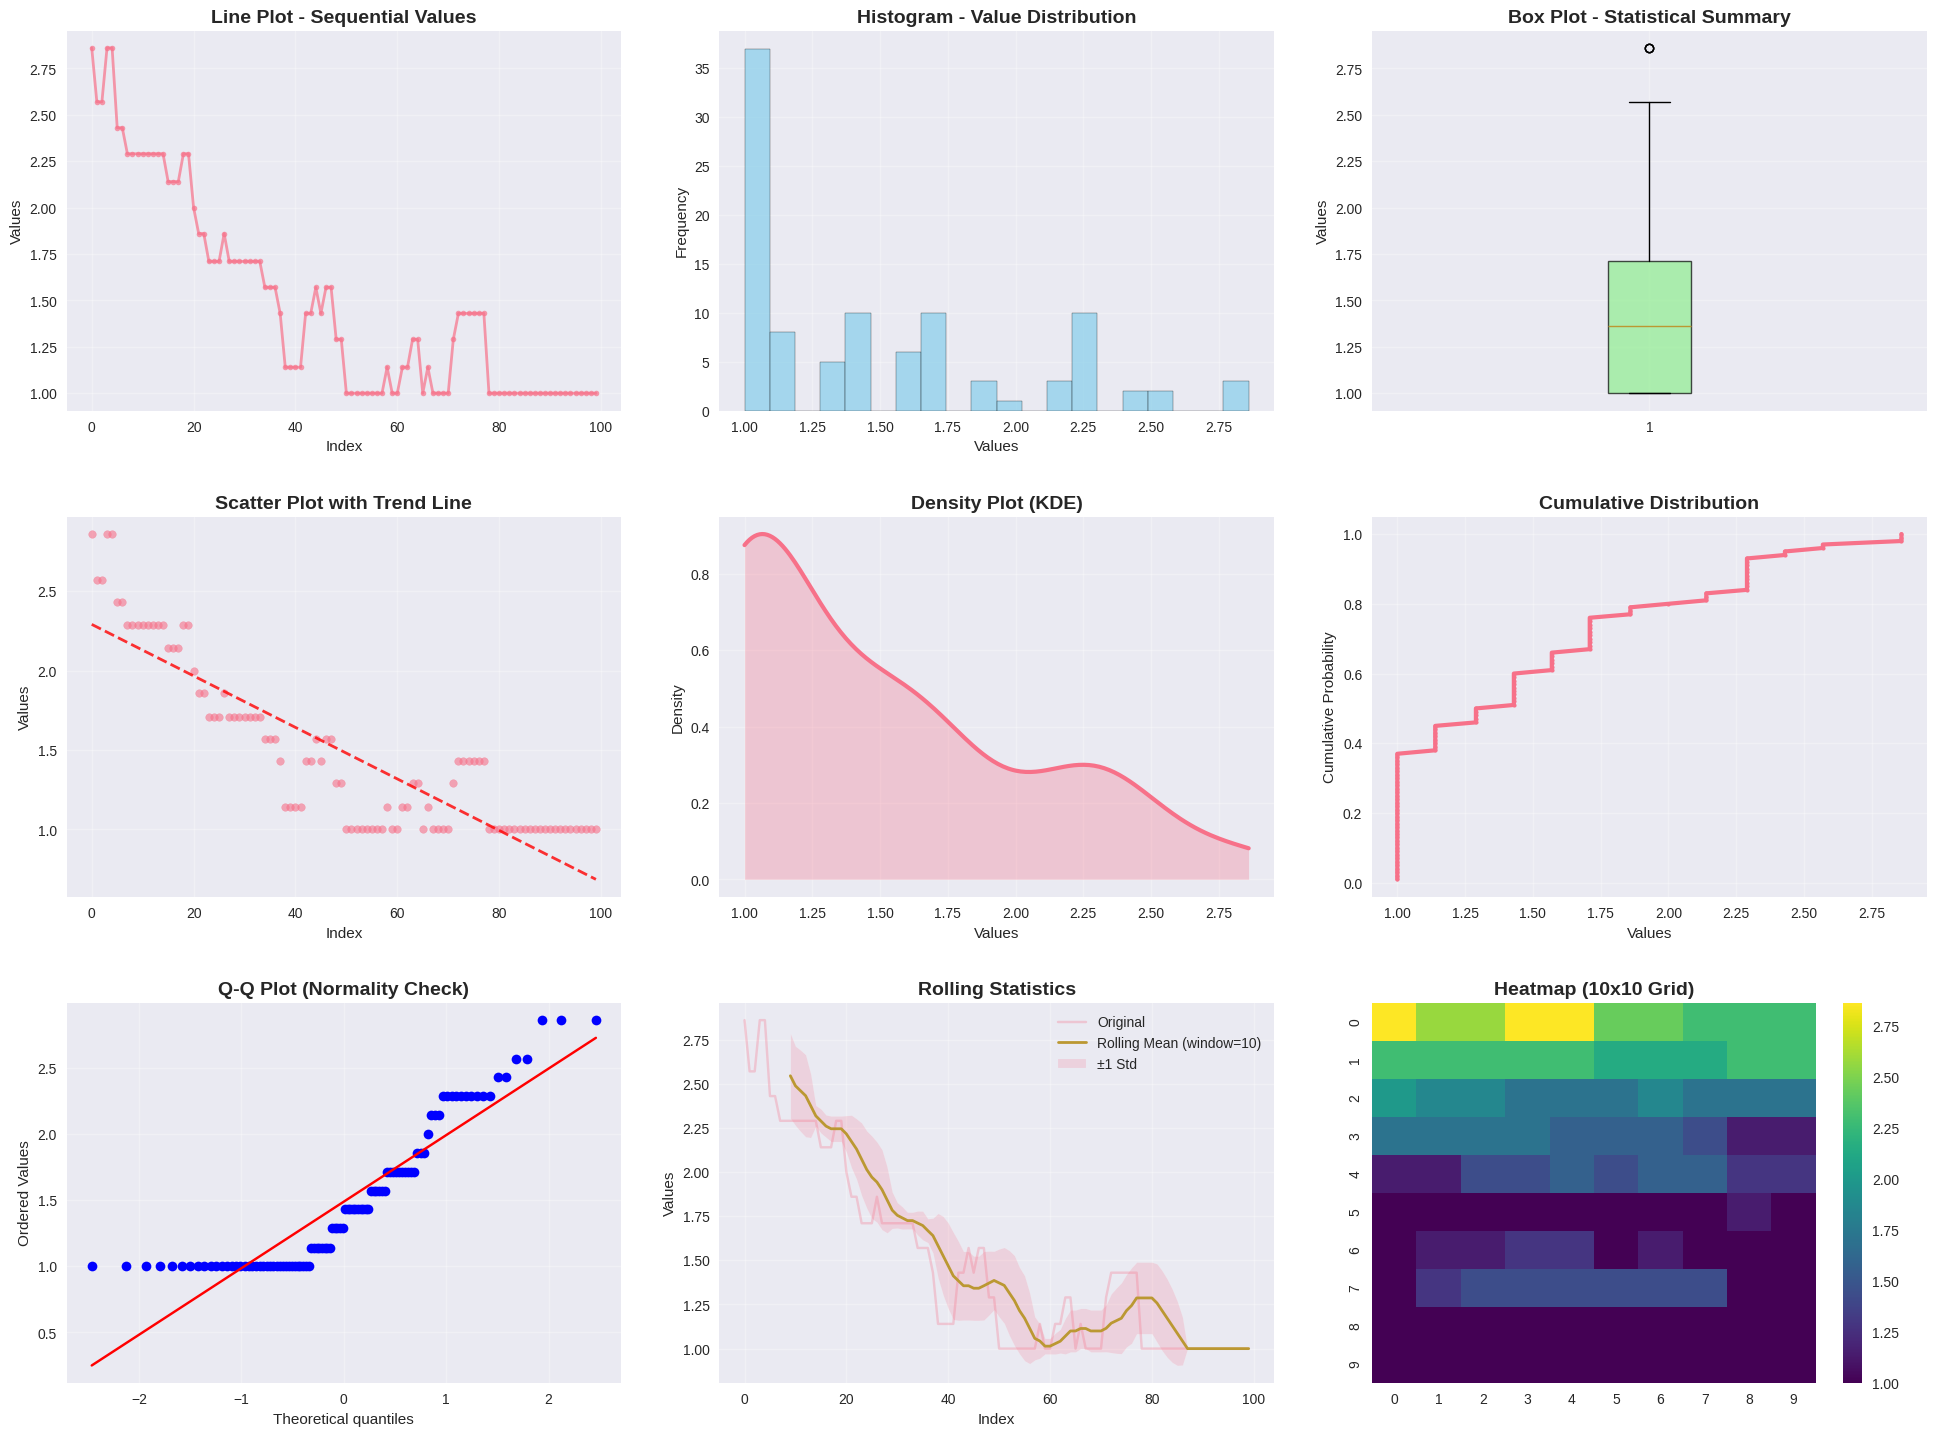

DATASET SUMMARY STATISTICS
Count: 100
Mean: 1.4887
Median: 1.3600
Std Dev: 0.5356
Min: 1.0000
Max: 2.8600
Range: 1.8600
Skewness: 0.8854
Kurtosis: -0.3321


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd

def plotting(set_values):

    # Set style for better visualization
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Line Plot - Basic time series view
    plt.subplot(3, 3, 1)
    plt.plot(range(len(set_values)), set_values, linewidth=2, marker='o', markersize=4, alpha=0.7)
    plt.title('Line Plot - Sequential Values', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True, alpha=0.3)

    # 2. Histogram - Distribution analysis
    plt.subplot(3, 3, 2)
    plt.hist(set_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Histogram - Value Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # 3. Box Plot - Statistical summary
    plt.subplot(3, 3, 3)
    plt.boxplot(set_values, patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7))
    plt.title('Box Plot - Statistical Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Values')
    plt.grid(True, alpha=0.3)

    # 4. Scatter Plot with trend line
    plt.subplot(3, 3, 4)
    x = range(len(set_values))
    plt.scatter(x, set_values, alpha=0.6, s=30)
    z = np.polyfit(x, set_values, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.8, linewidth=2)
    plt.title('Scatter Plot with Trend Line', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True, alpha=0.3)

    # 5. Density Plot (KDE)
    plt.subplot(3, 3, 5)
    density = stats.gaussian_kde(set_values)
    xs = np.linspace(min(set_values), max(set_values), 200)
    plt.plot(xs, density(xs), linewidth=3)
    plt.fill_between(xs, density(xs), alpha=0.3)
    plt.title('Density Plot (KDE)', fontsize=14, fontweight='bold')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)

    # 6. Cumulative Distribution
    plt.subplot(3, 3, 6)
    sorted_values = np.sort(set_values)
    cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    plt.plot(sorted_values, cumulative, linewidth=3, marker='o', markersize=3)
    plt.title('Cumulative Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Values')
    plt.ylabel('Cumulative Probability')
    plt.grid(True, alpha=0.3)

    # 7. Q-Q Plot for normality check
    plt.subplot(3, 3, 7)
    stats.probplot(set_values, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 8. Rolling Statistics (if applicable)
    plt.subplot(3, 3, 8)
    window = 10
    if len(set_values) >= window:
        rolling_mean = pd.Series(set_values).rolling(window=window).mean()
        rolling_std = pd.Series(set_values).rolling(window=window).std()

        plt.plot(range(len(set_values)), set_values, alpha=0.3, label='Original')
        plt.plot(range(len(set_values)), rolling_mean, linewidth=2, label=f'Rolling Mean (window={window})')
        plt.fill_between(range(len(set_values)),
                        rolling_mean - rolling_std,
                        rolling_mean + rolling_std,
                        alpha=0.2, label='±1 Std')
        plt.legend()
        plt.title('Rolling Statistics', fontsize=14, fontweight='bold')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.grid(True, alpha=0.3)

    # 9. Heatmap (reshape to 10x10 grid)
    plt.subplot(3, 3, 9)
    if len(set_values) == 100:
        heatmap_data = np.array(set_values).reshape(10, 10)
        sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar=True)
        plt.title('Heatmap (10x10 Grid)', fontsize=14, fontweight='bold')
    else:
        # Alternative: correlation heatmap with lag
        lags = range(1, min(21, len(set_values)//2))
        autocorr = [np.corrcoef(set_values[:-lag], set_values[lag:])[0,1] for lag in lags]
        plt.plot(lags, autocorr, marker='o', linewidth=2)
        plt.title('Autocorrelation Function', fontsize=14, fontweight='bold')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.grid(True, alpha=0.3)

    plt.tight_layout(pad=3.0)
    plt.show()

    # Additional: Summary statistics
    print("="*50)
    print("DATASET SUMMARY STATISTICS")
    print("="*50)
    print(f"Count: {len(set_values)}")
    print(f"Mean: {np.mean(set_values):.4f}")
    print(f"Median: {np.median(set_values):.4f}")
    print(f"Std Dev: {np.std(set_values):.4f}")
    print(f"Min: {np.min(set_values):.4f}")
    print(f"Max: {np.max(set_values):.4f}")
    print(f"Range: {np.max(set_values) - np.min(set_values):.4f}")
    print(f"Skewness: {stats.skew(set_values):.4f}")
    print(f"Kurtosis: {stats.kurtosis(set_values):.4f}")
plotting(set_values)

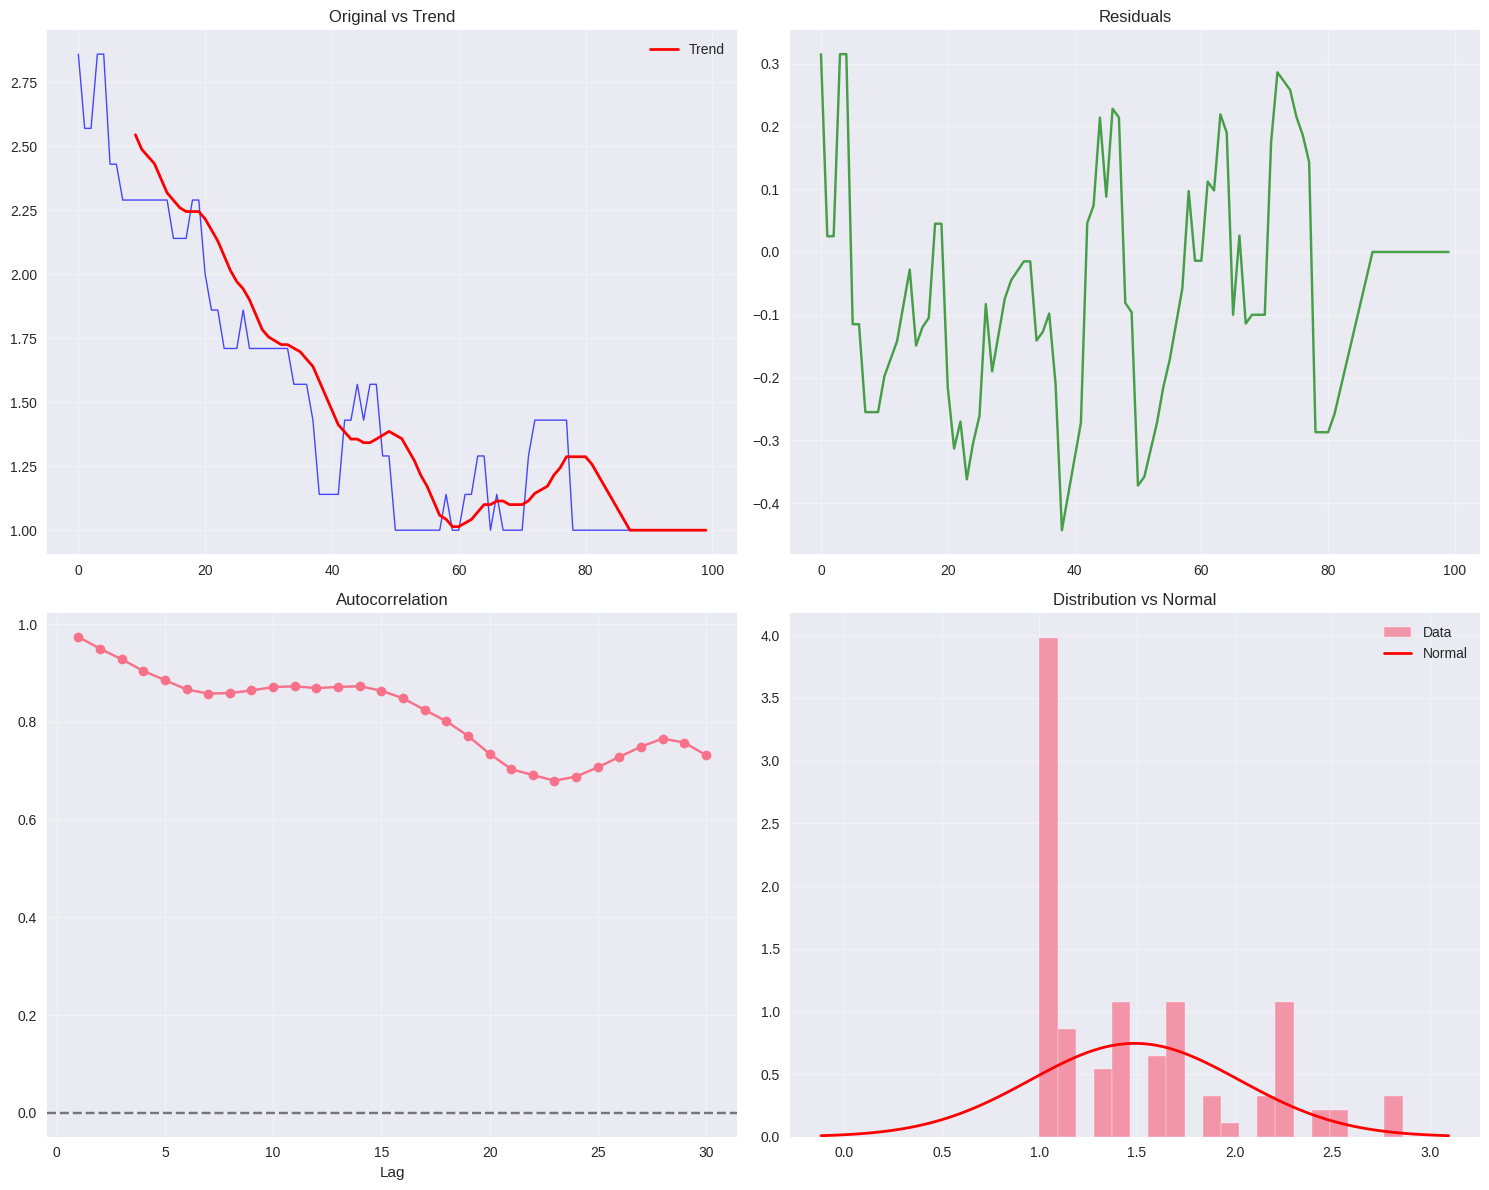

In [12]:
def plot_simple_line():
    """Simple line plot function"""
    plt.figure(figsize=(12, 6))
    plt.plot(set_values, linewidth=2, marker='o', markersize=4)
    plt.title('Set Values - Line Plot', fontsize=16, fontweight='bold')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_distribution():
    """Distribution analysis function"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram
    ax1.hist(set_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Histogram', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Values')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    # Box plot
    ax2.boxplot(set_values, patch_artist=True)
    ax2.set_title('Box Plot', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Values')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_advanced_analysis():
    """Advanced statistical analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Time series decomposition-like plot
    axes[0,0].plot(set_values, 'b-', alpha=0.7, linewidth=1)
    axes[0,0].plot(pd.Series(set_values).rolling(10).mean(), 'r-', linewidth=2, label='Trend')
    axes[0,0].set_title('Original vs Trend')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Residuals
    trend = pd.Series(set_values).rolling(10).mean().bfill().ffill()
    residuals = np.array(set_values) - np.array(trend)
    axes[0,1].plot(residuals, 'g-', alpha=0.7)
    axes[0,1].set_title('Residuals')
    axes[0,1].grid(True, alpha=0.3)

    # Autocorrelation plot
    lags = range(1, min(31, len(set_values)//3))
    autocorr = [np.corrcoef(set_values[:-lag], set_values[lag:])[0,1] for lag in lags if lag < len(set_values)]
    axes[1,0].plot(lags[:len(autocorr)], autocorr, 'o-')
    axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1,0].set_title('Autocorrelation')
    axes[1,0].set_xlabel('Lag')
    axes[1,0].grid(True, alpha=0.3)

    # Distribution comparison with normal
    axes[1,1].hist(set_values, bins=20, density=True, alpha=0.7, label='Data')
    mu, sigma = np.mean(set_values), np.std(set_values)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    axes[1,1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    axes[1,1].set_title('Distribution vs Normal')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Uncomment to use individual plotting functions:
# plot_simple_line()
# plot_distribution()
plot_advanced_analysis()

# comparative analysis

In [63]:
a = [0.024703, 0.203557, 0.170949, 0.408103, 0.192688]
sum(a)

1.0

In [64]:
test_series, gap_info = kz.generate_synthetic_gaps(power_series, perc_gaps = 50, gap_type_weights = [0.024703, 0.203557, 0.170949, 0.408103, 0.192688])
results_df = research_stage(test_series, gap_info)
rank_value = ranking(results_df)
results_df

,MAE,RMSE,MAPE,R2,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Time
Method,,,,,,,,,
KZImputer,1.477416,1.884927,7.040405,0.881569,0.095911,0.300488,0.437064,0.020799,0.004773
Mean,5.755274,6.455993,33.842065,-0.271443,0.316859,0.501772,2.877637,0.268066,0.002882
Median,5.106670,5.778189,27.845913,-0.018484,0.283592,0.478796,2.553335,0.233428,0.003092
Forward Fill,2.503808,3.240966,13.958254,0.679580,0.159066,0.412234,0.490118,0.066531,0.000167
Backward Fill,1.741404,2.165545,9.310118,0.856944,0.106284,0.370371,0.520908,0.029095,0.000166
Linear Interpolate,1.520799,1.914657,8.346047,0.888171,0.093971,0.291874,0.365477,0.023011,0.000475
Spline Interpolate,1.645797,2.155706,9.138884,0.858241,0.105802,0.306609,0.321216,0.029034,0.000739
KNN (k=5),5.755274,6.455993,33.842065,-0.271443,0.316859,0.501772,2.877637,0.268066,0.003765
IterativeImputer,5.755274,6.455993,33.842065,-0.271443,0.316859,0.501772,2.877637,0.268066,0.002964


In [33]:
rank_value

np.float64(1.57)

In [65]:
ranks_df = pd.DataFrame(index=results_df.index, columns=minimize_metrics[:-1])

for metric in minimize_metrics[:-1]:
    if metric in minimize_metrics[:-1]:
        ranks_df[metric] = results_df[metric].rank(ascending=True)
    else:
        ranks_df[metric] = results_df[metric].rank(ascending=False)

# add Average_rank
col_avg = 'Average_rank'
ranks_df[col_avg] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values(col_avg)

# print(f"\nBest method by average rank: {ranks_df.index[0]}\n")
ranks_df = ranks_df.round(2).sort_values(by=col_avg)
ranks_df
# rank_value = ranks_df[ranks_df.index == 'KZImputer']['Average_rank'].values
# rank_value

,MAE,RMSE,MAPE,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Average_rank
Method,,,,,,,,
KZImputer,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.57
Linear Interpolate,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.71
Spline Interpolate,3.0,3.0,3.0,3.0,3.0,1.0,3.0,2.71
Backward Fill,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.14
Forward Fill,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.86
Median,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.00
Mean,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.00
KNN (k=5),8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.00
IterativeImputer,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.00


# optimization searching

In [ ]:
!pip install optuna #-dashboard

In [ ]:
optuna.__version__

In [ ]:
import optuna
from functools import partial

def objective(trial, power_series):
    # 1. perc_gaps: от 5 до 50 включительно с шагом 5
    perc_gaps = trial.suggest_int("perc_gaps", 5, 70, step=1)

    # 2. gap_type_weights: 5 весов [w1, ..., w5], сумма = 1
    gaps = gaps = [trial.suggest_float(f"gaps_{i}", 0.01, 5.0, step=0.01) for i in range(5)]
    weights = np.random.dirichlet(gaps).tolist()

    try:
        # 3. Генерация пропусков
        test_series, gap_info = kz.generate_synthetic_gaps(
            power_series,
            perc_gaps=perc_gaps,
            gap_type_weights=weights
        )

        # 4. Исследование и ранжирование
        results_df = research_stage(test_series, gap_info)
        rank_value = ranking(results_df)

    except Exception as e:
        print(f"Trial failed: {e}")
        return float("inf")  # наказание за неудачный запуск

    return rank_value  # минимизируем

# Настройка optuna
# if __name__ == "__main__":
#     study = optuna.create_study(direction="minimize",
#         storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
#         study_name="quadratic-simple"
#     )
#     study.optimize(partial(objective, power_series=power_series), n_trials=100)
#     print("Best rank_value:", study.best_value)
#     print("Best params:", study.best_params)

study = optuna.create_study(direction="minimize")
study.optimize(partial(objective, power_series=power_series), n_trials=100)

# opsd_germany_daily
# Best rank_value: 1.86
# Best params: {'perc_gaps': 50, 'alpha_0': 0.31, 'alpha_1': 1.51, 'alpha_2': 0.060000000000000005, 'alpha_3': 1.62, 'alpha_4': 0.72}
# Best params: {'perc_gaps': 35, 'alpha_0': 2.5, 'alpha_1': 0.9500000000000001, 'alpha_2': 0.85, 'alpha_3': 0.36000000000000004, 'alpha_4': 2.6199999999999997}

# T1
# Best rank_value: 1.71
# Best params: {'perc_gaps': 65, 'alpha_0': 1.86, 'alpha_1': 3.0, 'alpha_2': 1.16, 'alpha_3': 1.86, 'alpha_4': 2.04}

# uswtdb_v3_0_1_20200514
# Best rank_value: 1.14
# Best params: {'perc_gaps': 45, 'gaps_0': 0.3, 'gaps_1': 2.66, 'gaps_2': 2.34, 'gaps_3': 2.69, 'gaps_4': 1.25}

print("Best rank_value:", study.best_value)
print("Best params:", study.best_params)

In [60]:
# fig1 = optuna.visualization.plot_param_importances(study)
# fig1.show()
limits = 1.5
filtered_data = []
for trial in study.trials:
    # Успешно завершенные триалы с нужным значением
    if trial.state == optuna.trial.TrialState.COMPLETE and trial.values and trial.values[0] < limits:
        # Собираем все 'gaps' параметры в один список
        gap_params = [
            trial.params.get(f'gaps_{i}', 0) for i in range(5) # .get для безопасности
        ]

        filtered_data.append({
            'number': trial.number,
            'value': trial.values[0],
            'perc_gaps': trial.params.get('perc_gaps'),
            'gap_params_raw': gap_params
        })

if not filtered_data:
    print(f"Не найдено триалов со значением < {limits}.")
else:
    # --- 2. Нормировка и обработка ---
    processed_data = []
    for item in filtered_data:
        raw_gaps = np.array(item['gap_params_raw'])

        # Нормализация к сумме, равной 1
        total_sum = raw_gaps.sum()
        normalized_gaps = raw_gaps / total_sum if total_sum > 0 else np.zeros_like(raw_gaps)

        new_item = {
            'Trial №': item['number'],
            'Value (Loss)': item['value'],
            '% Gaps': item['perc_gaps'],
        }
        for i, norm_val in enumerate(normalized_gaps):
            new_item[f'gap_{i}_norm'] = norm_val

        processed_data.append(new_item)

    # --- 3. Сортировка ---
    sorted_data = sorted(processed_data, key=lambda x: x['Value (Loss)'])

    # --- 4. Вывод в виде таблицы Pandas ---
    df_param_results = pd.DataFrame(sorted_data)

    # Форматирование для красивого вывода
    float_cols = [col for col in df_param_results.columns if 'Value' in col or 'gap' in col]
    formatters = {col: '{:.4f}'.format for col in float_cols}

    print(f"Лучшие триалы (Value < {limits}), отсортированные по возрастанию:")
    # Устанавливаем опцию, чтобы pandas не переносил строки
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(df_param_results.to_string(index=False, formatters=formatters))

Лучшие триалы (Value < 1.5), отсортированные по возрастанию:
 Trial № Value (Loss)  % Gaps gap_0_norm gap_1_norm gap_2_norm gap_3_norm gap_4_norm
      19       1.1400      27     0.2173     0.1507     0.1690     0.2037     0.2593
      76       1.1400      26     0.2169     0.1630     0.2540     0.0277     0.3384
      79       1.1400      21     0.1750     0.2066     0.2529     0.0644     0.3012
      23       1.2900      30     0.2442     0.1101     0.2071     0.1734     0.2653
      78       1.2900      21     0.1816     0.1742     0.2610     0.0701     0.3131
      74       1.4300      61     0.2489     0.1905     0.2547     0.0650     0.2409


In [61]:
from tqdm.auto import tqdm

best_rank_so_far = float('inf')  # Начинаем с бесконечности, ищем минимум
best_params_row = None           # Здесь будет храниться лучшая строка из df_results

print(f"--- Запуск валидации по {len(df_results)} наборам параметров из df_results ---")

# --- 2. Основной цикл по строкам df_results ---
# tqdm создает progress bar для отслеживания процесса
for index, row in tqdm(df_results.iterrows(), total=df_results.shape[0], desc="Валидация параметров"):

    # Шаг 2.1: Извлекаем параметры из текущей строки
    perc_gaps_from_row = row['% Gaps']

    # Собираем веса из колонок 'gap_0_norm', 'gap_1_norm', ...
    # Динамически находим все колонки, относящиеся к весам
    gap_weight_cols = [col for col in df_results.columns if 'gap_' in col and '_norm' in col]
    gap_weights_from_row = [row[col] for col in gap_weight_cols]

    # Печатаем информацию о текущем прогоне
    print(f"\n--- Тестируем параметры из строки {index} (Trial №{row.get('Trial №', 'N/A')}) ---")
    print(f"  Процент пропусков: {perc_gaps_from_row}")
    print(f"  Веса типов пропусков: {[round(w, 4) for w in gap_weights_from_row]}")

    # Шаг 2.2: Запускаем ваш пайплайн с этими параметрами
    # ВАЖНО: нужно использовать один и тот же seed для всех прогонов,
    # чтобы сравнение было честным. Различаться должны только perc_gaps и weights.
    # Если kz уже создан с seed, то все в порядке.
    test_series, gap_info = kz.generate_synthetic_gaps(
        power_series,
        perc_gaps=perc_gaps_from_row,
        gap_type_weights=gap_weights_from_row
    )

    results_df_current = research_stage(test_series, gap_info)

    rank_value = ranking(results_df_current)

    print(f"  --> Полученный ранг: {rank_value:.4f}")

    # Шаг 2.3: Проверяем, является ли текущий результат лучшим, и запоминаем строку
    if rank_value < best_rank_so_far:
        print(f"  *** Новый лучший ранг найден! (Предыдущий: {best_rank_so_far:.4f}) ***")
        best_rank_so_far = rank_value
        best_params_row = row.copy() # Сохраняем КОПИЮ лучшей строки


# --- 3. Выводим итоговый лучший результат ---
print("\n\n========================================================")
print("      ИТОГОВЫЙ ЛУЧШИЙ РЕЗУЛЬТАТ")
print("========================================================")

if best_params_row is not None:
    print(f"Найден минимальный ранг: {best_rank_so_far:.4f}")
    print("\nЭтот ранг был достигнут при следующих параметрах:")

    # Преобразуем Series в DataFrame для красивого вывода
    best_params_df = pd.DataFrame(best_params_row).transpose()

    # Устанавливаем опции для полного отображения
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(best_params_df.to_string())
else:
    print("\nНе удалось завершить ни одного прогона или входной DataFrame был пуст.")

--- Запуск валидации по 20 наборам параметров из df_results ---


Валидация параметров:   0%|          | 0/20 [00:00<?, ?it/s]


--- Тестируем параметры из строки 0 (Trial №61.0) ---
  Процент пропусков: 49.0
  Веса типов пропусков: [np.float64(0.2266), np.float64(0.2125), np.float64(0.1382), np.float64(0.2016), np.float64(0.2211)]
  --> Полученный ранг: 1.7100
  *** Новый лучший ранг найден! (Предыдущий: inf) ***

--- Тестируем параметры из строки 1 (Trial №19.0) ---
  Процент пропусков: 47.0
  Веса типов пропусков: [np.float64(0.1149), np.float64(0.3041), np.float64(0.1122), np.float64(0.2706), np.float64(0.1982)]
  --> Полученный ранг: 1.7100

--- Тестируем параметры из строки 2 (Trial №49.0) ---
  Процент пропусков: 55.0
  Веса типов пропусков: [np.float64(0.2049), np.float64(0.2432), np.float64(0.165), np.float64(0.1879), np.float64(0.199)]
  --> Полученный ранг: 1.5700
  *** Новый лучший ранг найден! (Предыдущий: 1.7100) ***

--- Тестируем параметры из строки 3 (Trial №59.0) ---
  Процент пропусков: 59.0
  Веса типов пропусков: [np.float64(0.1839), np.float64(0.2312), np.float64(0.1246), np.float64(0.2442

# plotting

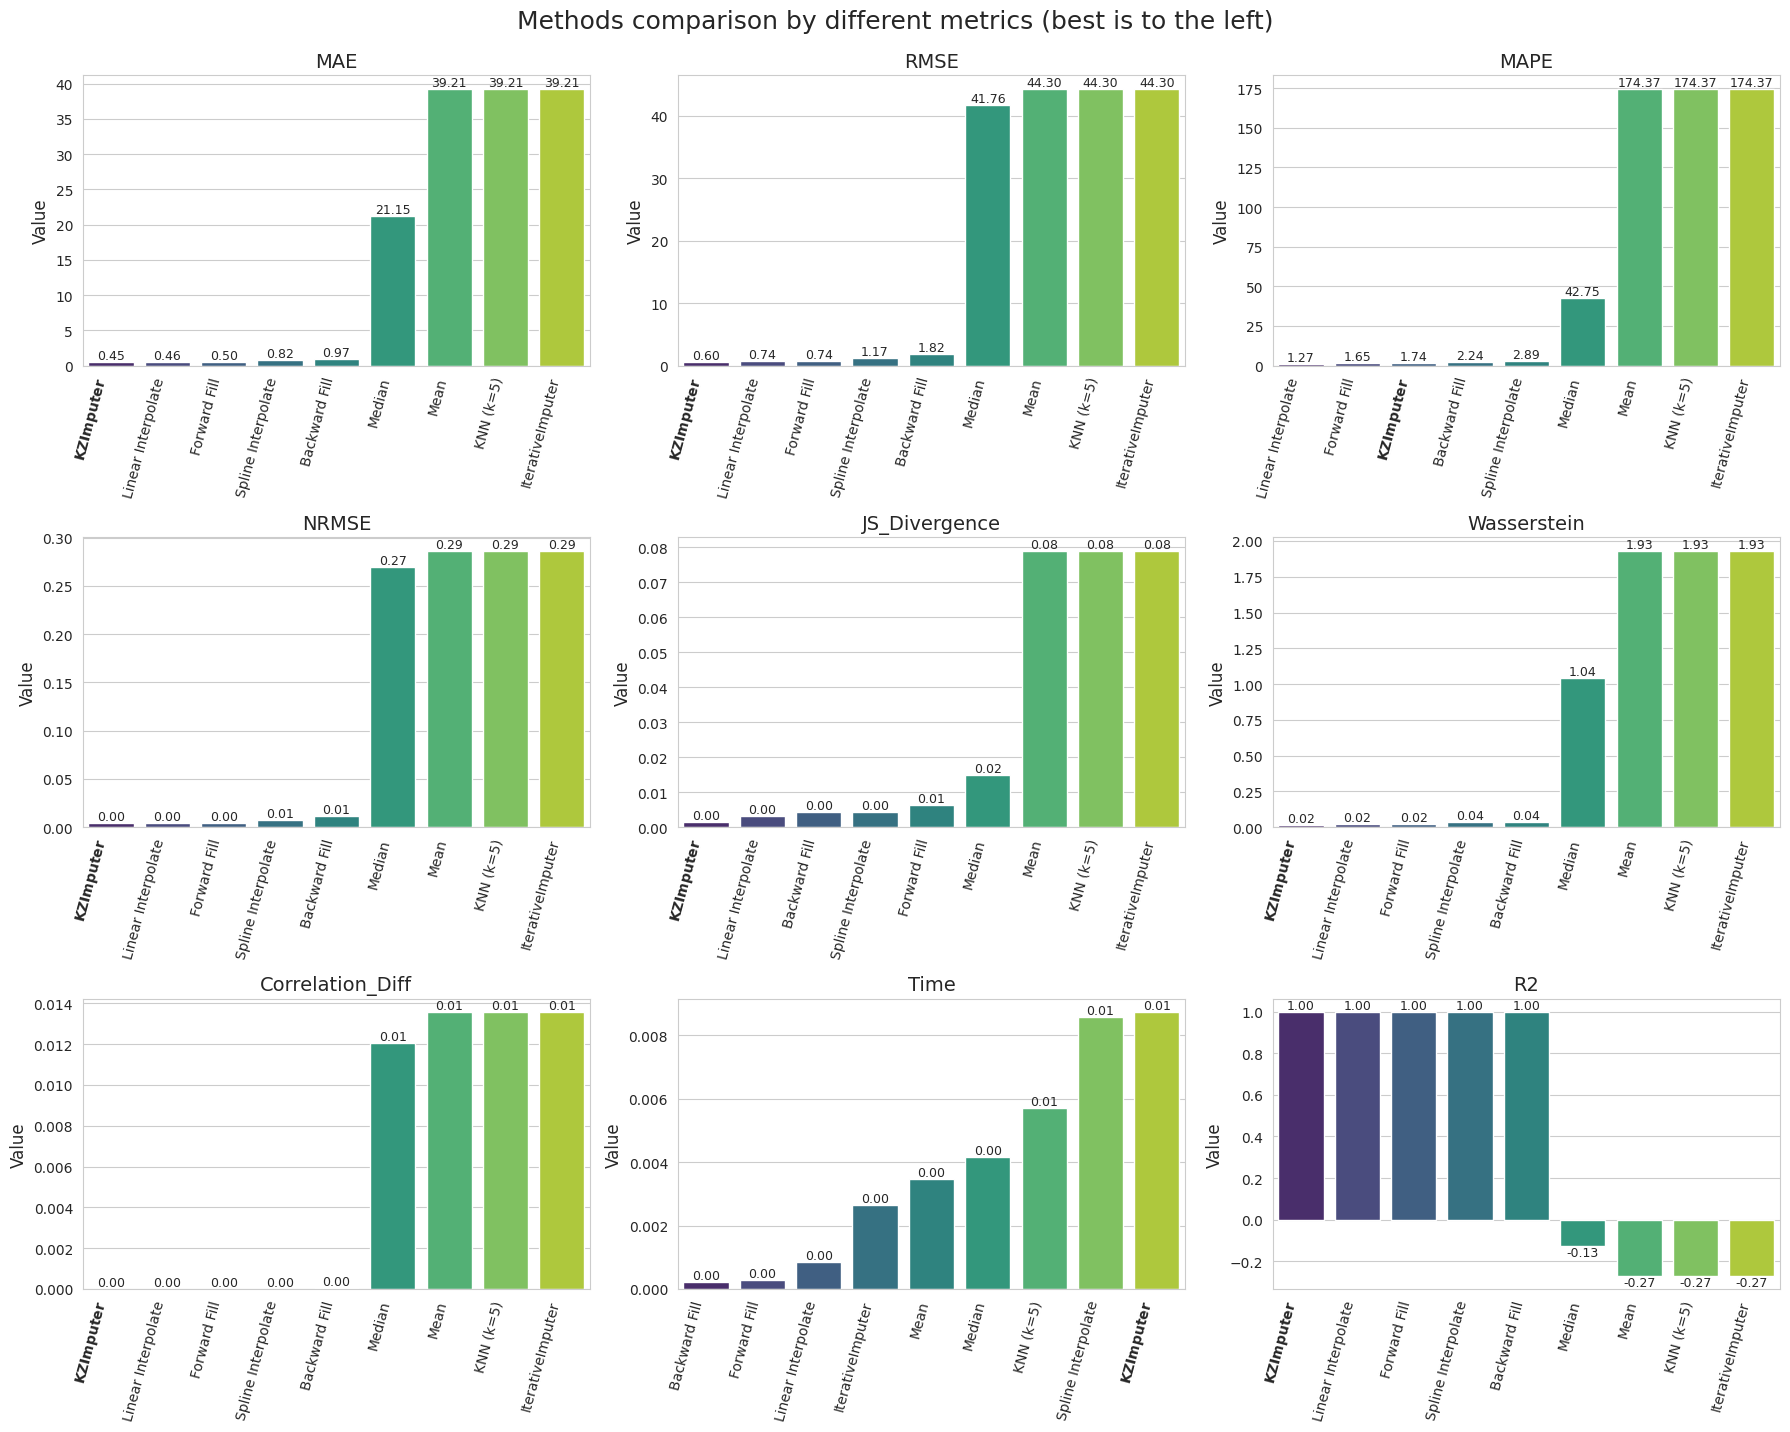

In [63]:
fig, axes = plt.subplots(3, 3, figsize = (18, 14))
axes = axes.flatten()

for i, metric in enumerate(all_metrics):
    ax = axes[i]
    # transform DataFrame with column "Method" and metric
    metric_df = results_df.reset_index()[['Method', metric]].copy()

    # sorting
    ascending = metric in minimize_metrics
    metric_df = metric_df.sort_values(by=metric, ascending=ascending)

    # highlight KZImputer (bold font)
    def format_label(method):
        return f"$\\bf{{{method}}}$" if method == "KZImputer" else method

    formatted_labels = [format_label(m) for m in metric_df['Method']]

    sns.barplot(
        data = metric_df,
        x = 'Method',
        y = metric,
        hue = 'Method',
        palette = 'viridis',
        legend = False,
        ax = ax
    )

    ax.set_title(metric, fontsize = 14)
    ax.set_ylabel('Value', fontsize = 12)
    ax.set_xlabel('')
    ax.set_xticks(range(len(formatted_labels)))
    ax.set_xticklabels(formatted_labels, rotation = 75, ha = 'right')

    for container in ax.containers:
        ax.bar_label(container, fmt = '%.2f', fontsize = 9)

if len(all_metrics) < len(axes):
    for j in range(len(all_metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle(f"Methods comparison by different metrics (best is to the left)\n dataset: {data_file_name}", fontsize = 18, y = 1.02)
plt.show()

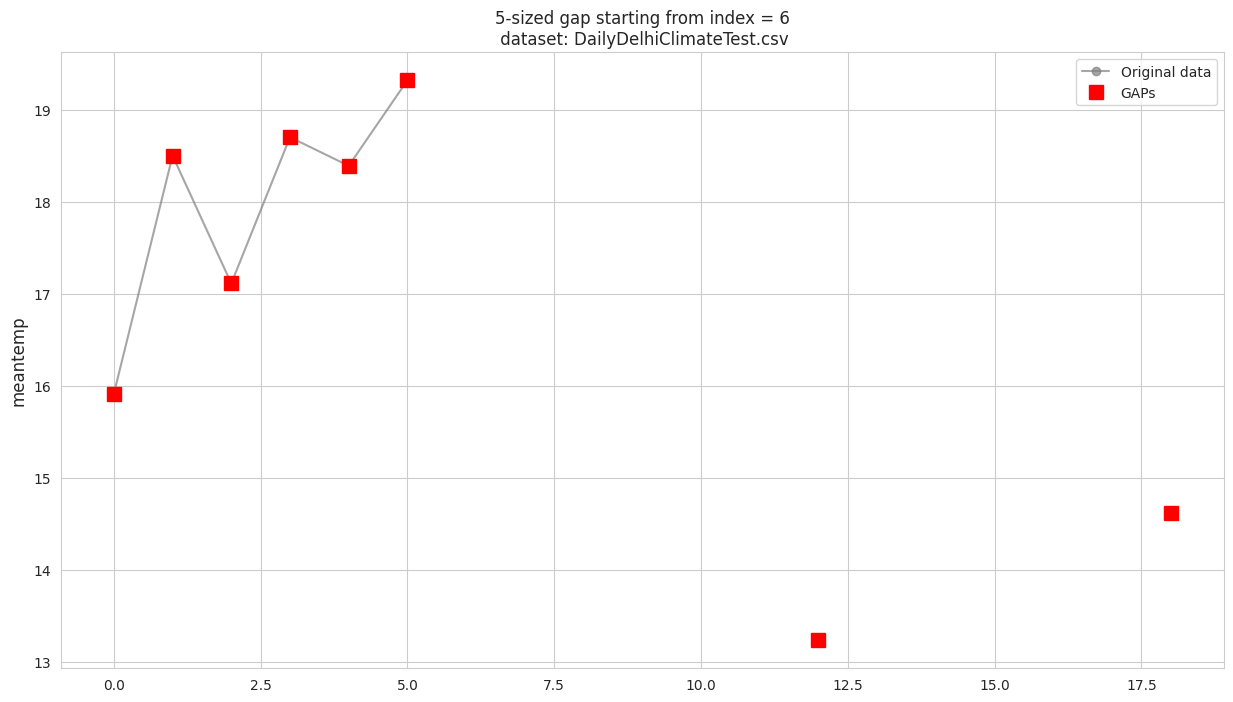

In [66]:
window_size = 5
rolling_na = test_series.isna().rolling(window_size).sum()
clean_slice = test_series.copy()
# indexes
gaps = rolling_na[rolling_na == window_size]

if gaps.empty:
    raise ValueError(f"❌ Did not find any block with {window_size}-sized consecutive missing values.")

gap_start = gaps.index[0]
gap_start_index = test_series.index.get_loc(gap_start) - (window_size - 1)

# slice arround gap
plot_slice = slice(max(0, gap_start_index - 10), min(len(test_series), gap_start_index + 15))

plt.figure(figsize = (15, 8))
plt.plot(clean_slice.iloc[plot_slice], 'o-', label = 'Original data', color = 'gray', alpha = 0.7)
plt.plot(test_series.iloc[plot_slice], 's', markersize = 10, label = 'GAPs', color = 'red')
plt.title(f'{window_size}-sized gap starting from index = {gap_start_index}\n dataset: {data_file_name}')
plt.ylabel(research_name_col, fontsize = 12)
plt.legend()
plt.grid(True)
plt.show()

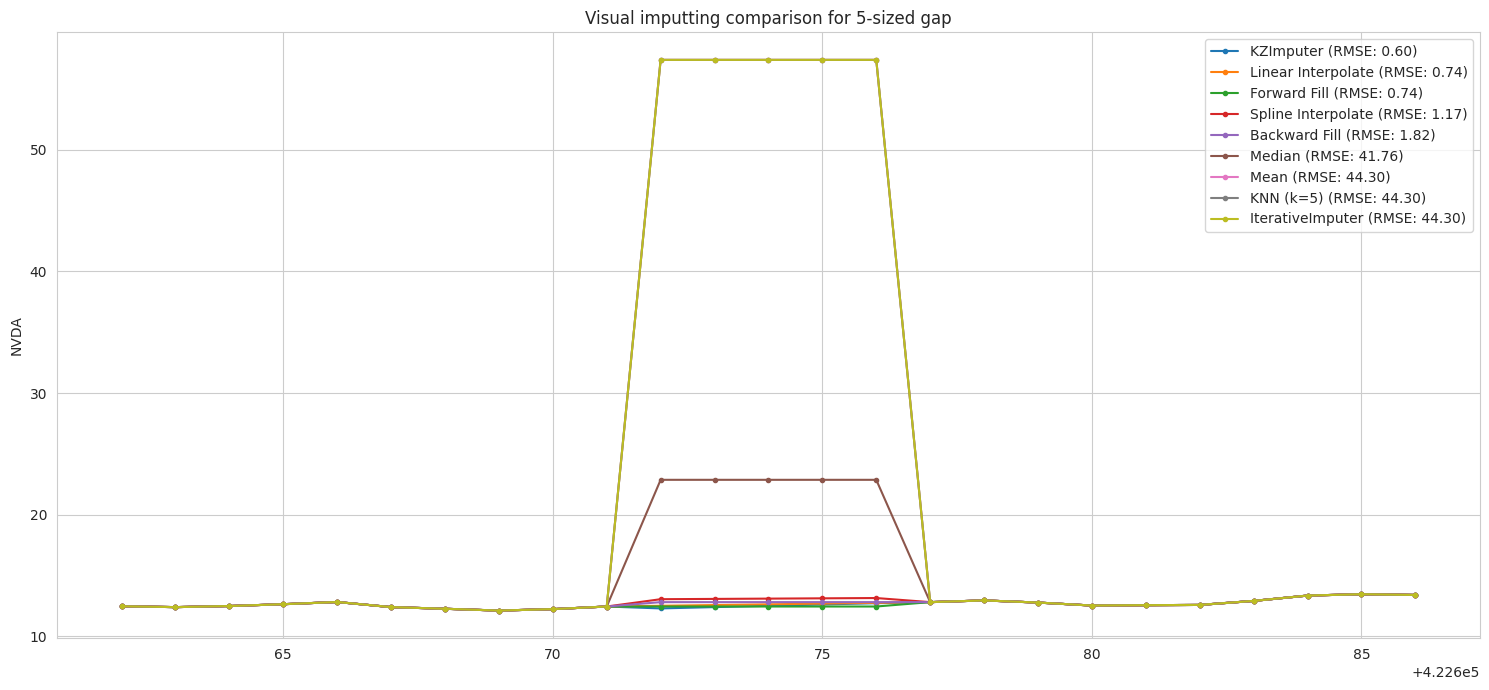

In [68]:
best_methods = results_df.sort_values('RMSE').index

for name in best_methods:
    if isinstance(imputers[name], str):
        if name == "Linear Interpolate":
            imputed = test_series.interpolate(method = 'linear')
        elif name == "Spline Interpolate":
            imputed = test_series.interpolate(method = 'spline', order = 3)
        else:
            if imputers[name] == 'ffill':
                imputed = test_series.ffill()
            elif imputers[name] == 'bfill':
                imputed = test_series.bfill()
            else:
                raise ValueError(f"Unknown imputting method: {imputers[name]}")
    elif name == "KZImputer":
        imputed = kz.transform(test_series)
    else:
        imputed_data = imputers[name].fit_transform(test_series.to_frame())
        imputed = pd.Series(imputed_data.flatten(), index=test_series.index)

    plt.plot(imputed.iloc[plot_slice], '.-', label = f'{name} (RMSE: {results_df.loc[name, "RMSE"]:.2f})')

plt.title(f'Visual imputting comparison for {max_gap}-sized gap\n dataset: {data_file_name}')
plt.legend()
plt.ylabel(research_name_col)
plt.grid(True)
plt.tight_layout()
plt.show()

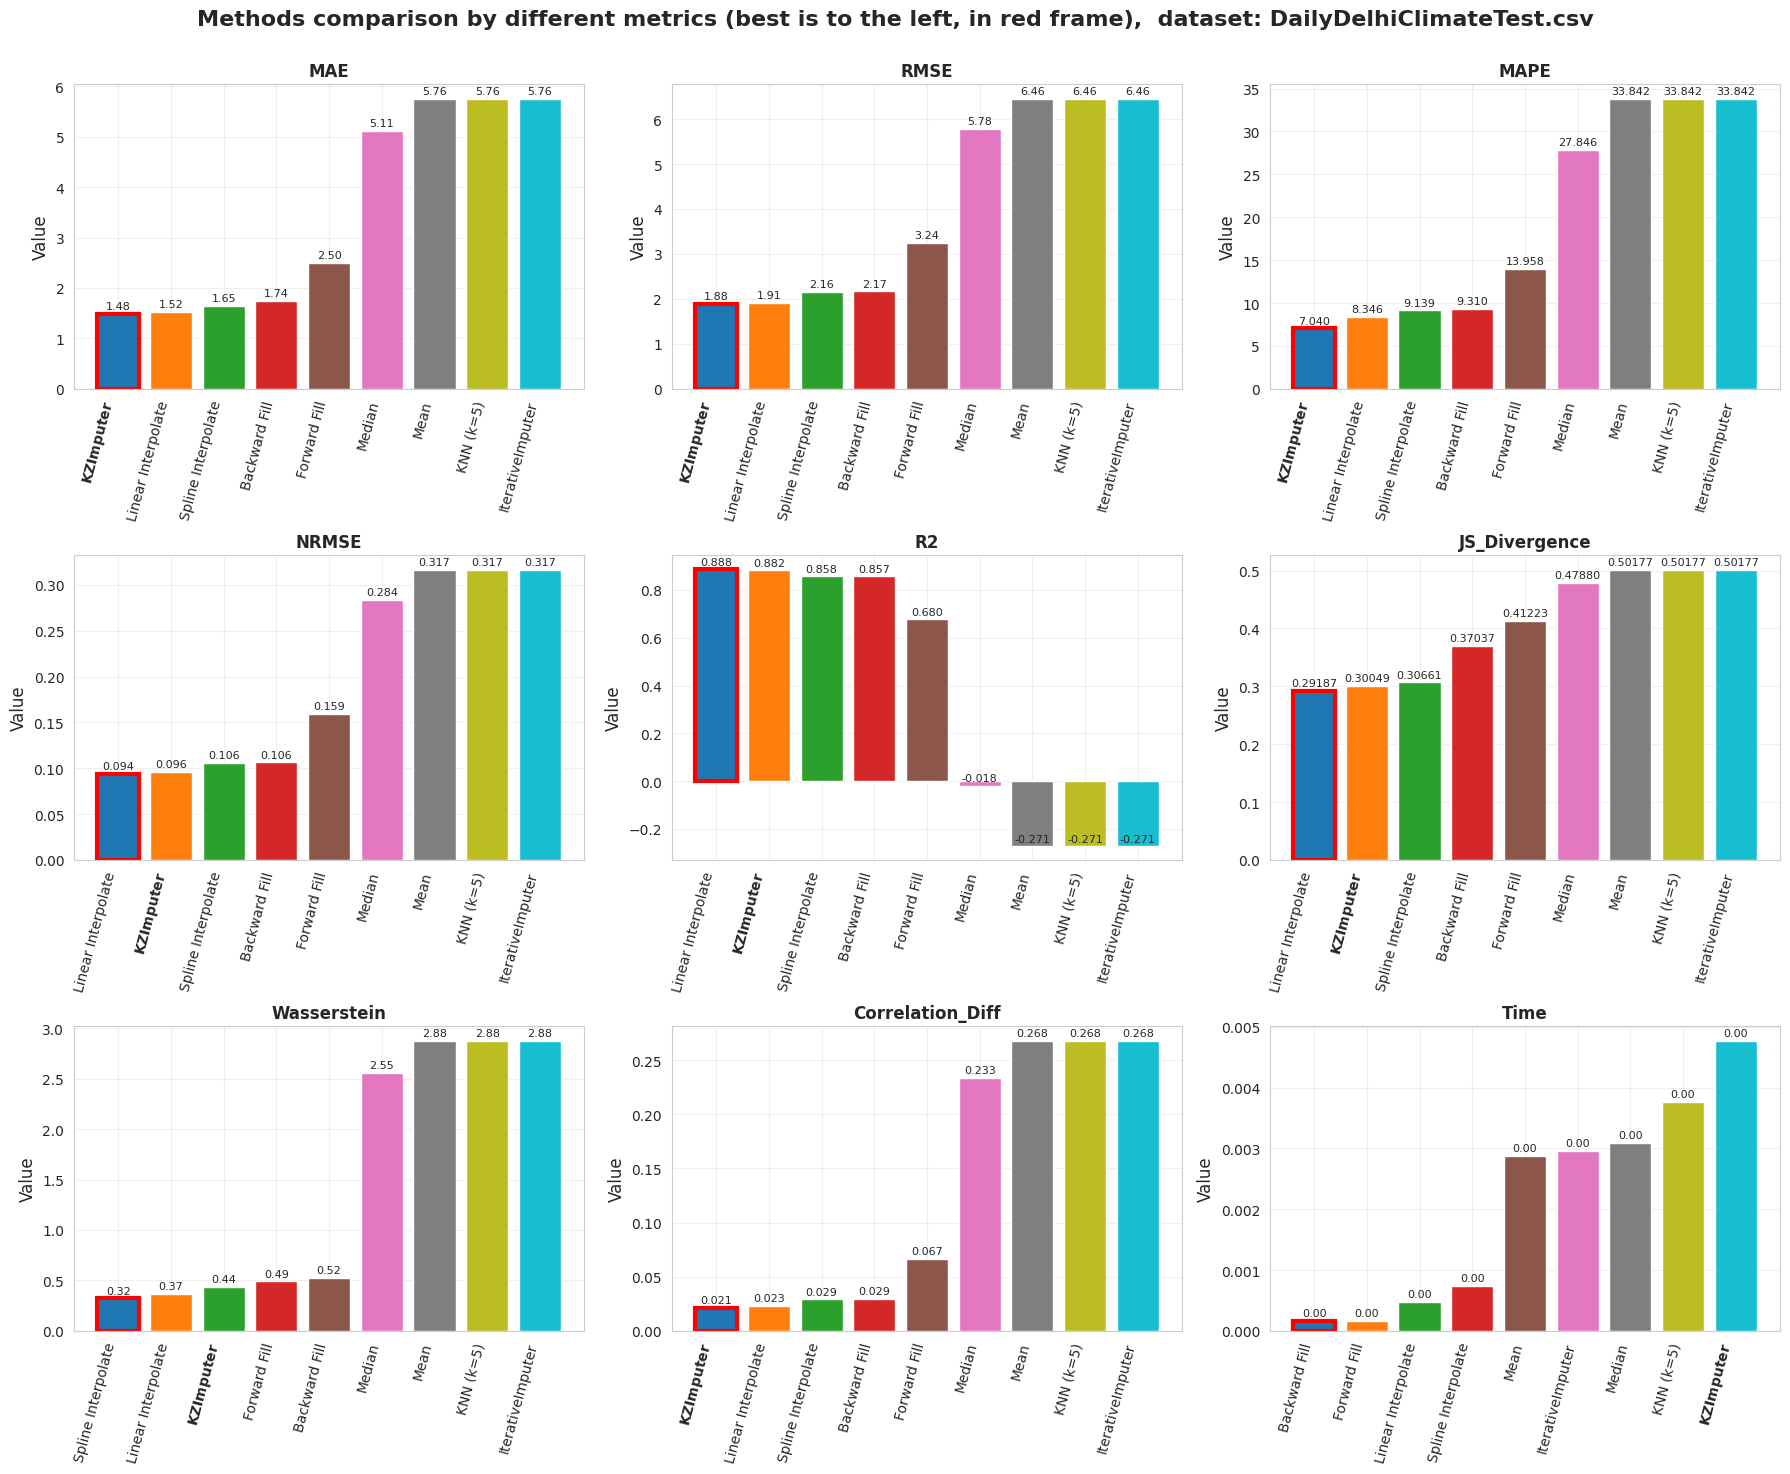

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Получите список всех методов из results_df
all_methods = results_df.index.tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(all_methods)))

def format_label(method):
    return f"$\\bf{{{method}}}$" if method == "KZImputer" else method

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    # Создайте DataFrame для текущей метрики
    metric_df = results_df.reset_index()[['Method', metric]].copy()

    # Сортировка по текущей метрике
    ascending = metric in minimize_metrics
    metric_df = metric_df.sort_values(by=metric, ascending=ascending)

    # Получите отсортированные значения и методы
    sorted_methods = metric_df['Method'].tolist()
    sorted_values = metric_df[metric].tolist()

    # Форматируйте labels для отсортированных методов
    formatted_labels = [format_label(m) for m in sorted_methods]

    # Постройте график с правильными данными
    bars = ax.bar(range(len(formatted_labels)), sorted_values, color=colors[:len(sorted_values)])

    ax.set_xticks(range(len(formatted_labels)))
    ax.set_xticklabels(formatted_labels, rotation=75, ha='right', fontsize=10)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Добавьте значения на столбцы
    for i, (bar, value) in enumerate(zip(bars, sorted_values)):
        if not np.isnan(value):
            if metric in ['MAPE', 'R2', 'NRMSE', 'Correlation_Diff']:
                text = f'{value:.3f}'
            elif metric == 'JS_Divergence':  # Исправлено: убрал список
                text = f'{value:.5f}'
            elif metric in ['MAE', 'RMSE', 'Wasserstein']:
                text = f'{value:.0f}' if value > 1000 else f'{value:.2f}'
            else:
                text = f'{value:.2e}' if abs(value) > 1e6 else f'{value:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2,
                   bar.get_height() + 0.01*max([v for v in sorted_values if not np.isnan(v)]),
                   text, ha='center', va='bottom', fontsize=8, rotation=0)

    # Выделите лучший результат (первый в отсортированном списке)
    if len(bars) > 0:
        bars[0].set_edgecolor('red')
        bars[0].set_linewidth(3)

# Если у вас только 8 метрик, скройте 9-й subplot
if len(all_main_metrics) < 9:
    axes[len(all_main_metrics)].set_visible(False)

plt.suptitle(f'Methods comparison by different metrics (best is to the left, in red frame),  dataset: {data_file_name}',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

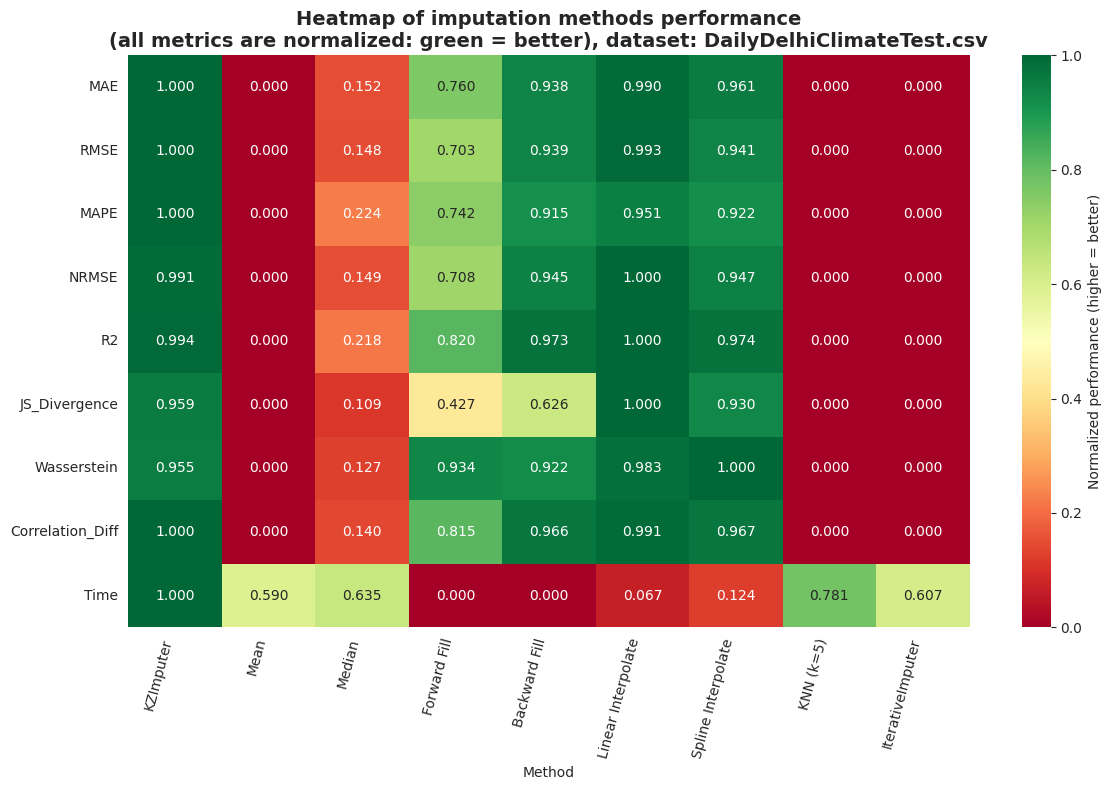

In [68]:
# Extra: Create a heat map for better visibility
plt.figure(figsize=(12, 8))

# Normalize data for heat map (0-1 scale for each metric)
normalized_data = results_df[all_main_metrics].copy()
for metric in all_main_metrics:
    if metric in minimize_metrics[:-1]:
        normalized_data[metric] = 1 - (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())
    else:
        normalized_data[metric] = (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())

# create heatmap
sns.heatmap(normalized_data.T,
           annot=True,
           fmt='.3f',
           cmap='RdYlGn',
           xticklabels=results_df.index,
           yticklabels=all_main_metrics,
           cbar_kws={'label': 'Normalized performance (higher = better)'})

plt.title(f'Heatmap of imputation methods performance\n(all metrics are normalized: green = better), dataset: {data_file_name}',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=75, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

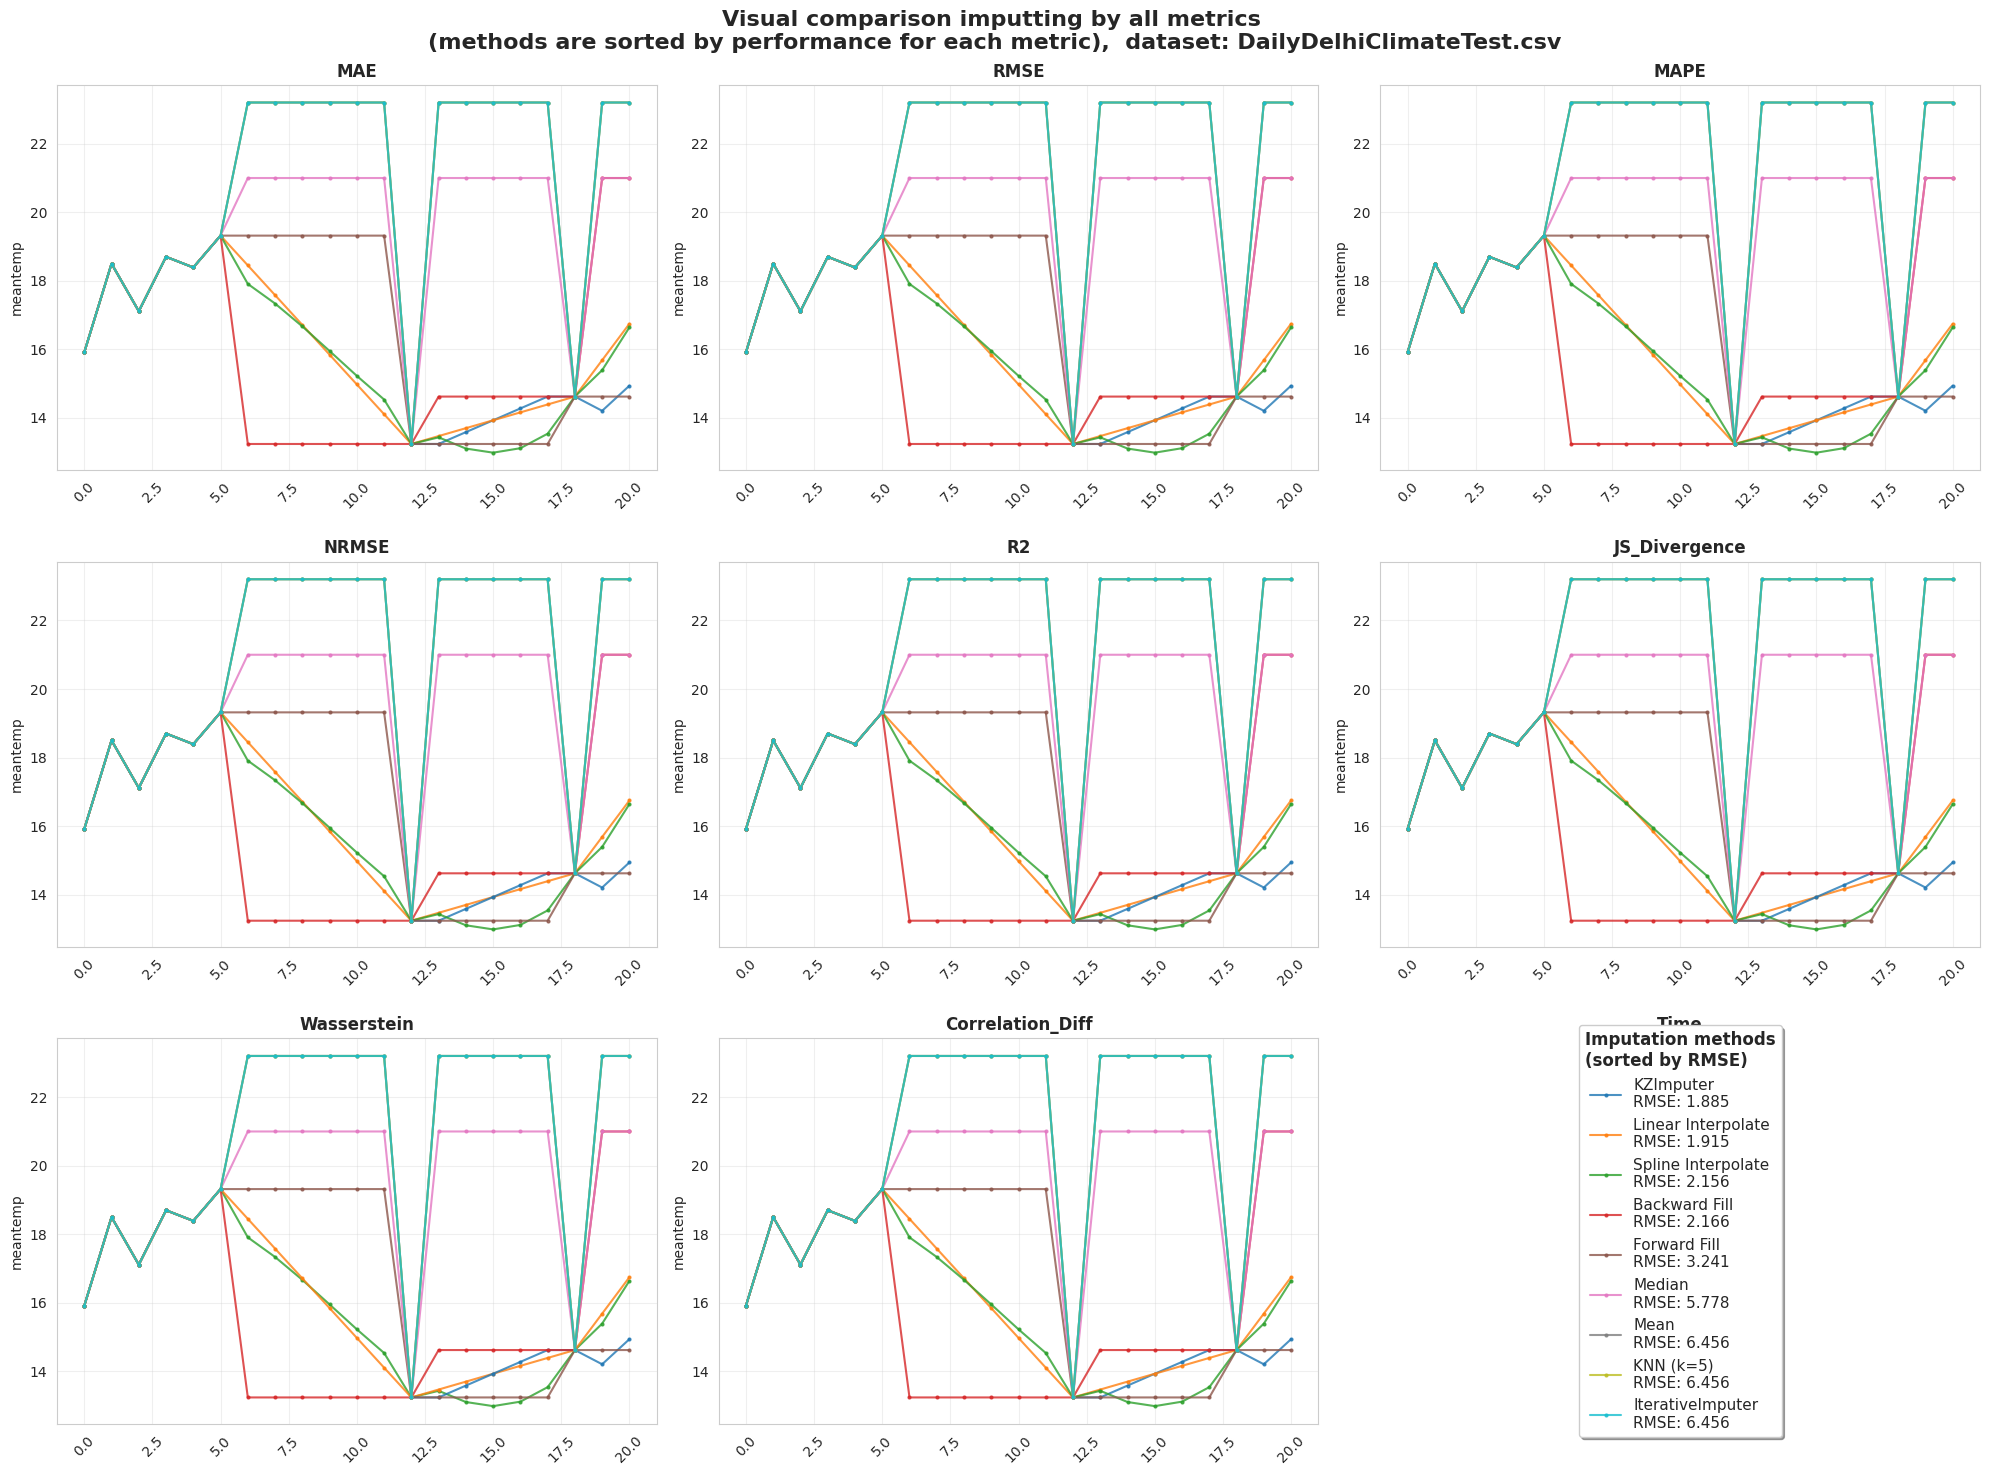

In [69]:
# create grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()
best_methods = results_df.sort_values('RMSE').index
# colors for methods
colors = plt.cm.tab10(np.linspace(0, 1, len(best_methods)))
color_dict = {method: colors[i] for i, method in enumerate(best_methods)}

legend_handles = []
legend_labels = []

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    if metric in minimize_metrics[:-1]:
        sorted_methods = results_df.sort_values(metric).index
    else:
        # for R2
        sorted_methods = results_df.sort_values(metric, ascending=False).index

    for i, name in enumerate(sorted_methods):
        if isinstance(imputers[name], str):
            if name == "Linear Interpolate":
                imputed = test_series.interpolate(method='linear')
            elif name == "Spline Interpolate":
                imputed = test_series.interpolate(method='spline', order=3)
            else:
                if imputers[name] == 'ffill':
                    imputed = test_series.ffill()
                elif imputers[name] == 'bfill':
                    imputed = test_series.bfill()
                else:
                    raise ValueError(f"Unknown imputting method: {imputers[name]}")
        elif name == "KZImputer":
            imputed = kz.transform(test_series)
        else:

            imputed_data = imputers[name].fit_transform(test_series.to_frame())
            imputed = pd.Series(imputed_data.flatten(), index=test_series.index)


        line = ax.plot(imputed.iloc[plot_slice], '.-',
                      color=color_dict[name],
                      alpha=0.8, linewidth=1.5, markersize=4)


        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append(f'{name}')

    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(research_name_col, fontsize=10)
    ax.grid(True, alpha=0.3)

    ax.tick_params(axis='x', rotation=45)

# set 9-th subplot as legend
legend_ax = axes[8]
legend_ax.set_xlim(0, 1)
legend_ax.set_ylim(0, 1)
legend_ax.axis('off')

# create separated legend
legend_text = []
for method in best_methods:
    metrics_str = f"RMSE: {results_df.loc[method, 'RMSE']:.3f}"
    legend_text.append(f"{method}\n{metrics_str}")

# Размещаем легенду
legend = legend_ax.legend(legend_handles, legend_text,
                         loc='center',
                         fontsize=11,
                         title='Imputation methods\n(sorted by RMSE)',
                         title_fontsize=12,
                         frameon=True,
                         fancybox=True,
                         shadow=True,
                         ncol=1)

legend.get_title().set_fontweight('bold')

plt.suptitle(f'Visual comparison imputting by all metrics \n(methods are sorted by performance for each metric),  dataset: {data_file_name}',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# research based on another DS

In [ ]:
def run_imputation_experiment(data_path, target_column, date_column=None, date_format=None, **kwargs):
    """
    Проводит полный эксперимент по сравнению методов импутации на заданном датасете.

    Параметры:
        data_path (str): Путь к CSV файлу.
        target_column (str): Название колонки с временным рядом.
        date_column (str, optional): Название колонки с датой/временем.
        date_format (str, optional): Формат даты для pd.to_datetime.
        **kwargs: Дополнительные аргументы для pd.read_csv (например, sep=',').
    """
    print(f"--- Запуск эксперимента для датасета: {data_path.split('/')[-1]} ---")

    # 1. Загрузка и подготовка данных
    df = pd.read_csv(data_path, **kwargs)

    if date_column:
        df[date_column] = pd.to_datetime(df[date_column], format=date_format)
        df = df.set_index(date_column)

    # Выбираем целевую колонку
    series = df[target_column].astype(float)

    # Обработка уже существующих пропусков (для чистоты эксперимента)
    series = series.dropna()

    if len(series) < 100:
        print("Датасет слишком короткий, пропускаем.")
        return None

    # 2. Создание искусственных пропусков
    np.random.seed(42)
    test_series = series.copy()

    # Масштабируем количество пропусков к размеру датасета
    num_single_gaps = max(10, int(len(test_series) * 0.01))
    num_triple_gaps = max(3, int(len(test_series) * 0.005))
    num_penta_gaps = max(2, int(len(test_series) * 0.003))

    for _ in range(num_single_gaps):
        idx = np.random.randint(10, len(test_series) - 10)
        test_series.iloc[idx] = np.nan
    for _ in range(num_triple_gaps):
        idx = np.random.randint(10, len(test_series) - 15)
        test_series.iloc[idx:idx+3] = np.nan
    for _ in range(num_penta_gaps):
        idx = np.random.randint(10, len(test_series) - 20)
        test_series.iloc[idx:idx+5] = np.nan

    missing_indices = test_series.isna()
    print(f"Внесено {missing_indices.sum()} пропусков ({missing_indices.sum()/len(series):.2%}).")

    # 3. Сравнение методов импутации
    imputers = {
        "KZImputer": KZImputer(max_gap_size=5),
        "Mean": SimpleImputer(strategy='mean'),
        "Median": SimpleImputer(strategy='median'),
        "Forward Fill": 'ffill',
        "Backward Fill": 'bfill',
        "Linear Interpolate": 'linear',
        "Spline Interpolate": 'spline',
        "KNN (k=5)": KNNImputer(n_neighbors=5),
        "IterativeImputer": IterativeImputer(max_iter=10, random_state=0)
    }

    results = []

    # For imputers that need a 2D array, we transform the data
    test_series_2d = test_series.to_frame()

    for name, imputer in imputers.items():
        start_time = time.time()

        if isinstance(imputer, str):
            if name == "Linear Interpolate":
                imputed_series = test_series.interpolate(method = "linear")
            elif name == "Spline Interpolate":
                imputed_series = test_series.interpolate(method = "spline", order = 3)
            elif name == "Forward Fill":
                imputed_series = test_series.ffill()
            elif name == "Backward Fill":
                imputed_series = test_series.bfill()
        elif name == "KZImputer":
            imputed_series = imputer.transform(test_series)
        else:
            imputed_data = imputer.fit_transform(test_series_2d)
            imputed_series = pd.Series(imputed_data.flatten(), index = test_series.index)

        elapsed = time.time() - start_time

        metrics = kz.evaluate_metrics(
            true_values = clean_slice[missing_indices],
            imputed_values = imputed_series[missing_indices],
            full_true = clean_slice,
            full_imputed = imputed_series
        )
        metrics["Time (s)"] = elapsed
        metrics["Method"] = name
        results.append(metrics)

    results_df = pd.DataFrame(results).set_index("Method")
    results_df = results_df[[
        "MAE", "RMSE", "MAPE", "R2", "NRMSE",
        "JS_Divergence", "Wasserstein", "Correlation_Diff",
        "Time (s)"
    ]]

    return results_df